In [1]:
import gpflow
import gpflux
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpflow.conditionals.logger.setLevel(level=0)
gpflow.logdensities.logger.setLevel(level=0)

In [2]:
float_type = gpflow.settings.float_type

class PlotDeepGP(gpflux.DeepGP):
    """ Adds plotting functionality to the model """
    
    @gpflow.decors.autoflow((float_type, [None, None]))
    def plot_layers(self, X):
        S = 5
        sample = X
        means, variances, samples = [], [], []
        for l in self.layers:
            m, v = l.propagate(sample, sampling=False, full_output_cov=False, full_cov=True)  # N x D, D x N x N
            N, D = tf.shape(m)[0], tf.shape(m)[1]
            jittermat = 1e-6 * tf.eye(N, batch_shape=[D], dtype=float_type)  # D x N x N
            L = tf.cholesky(v + jittermat)  # D x N x N
            nu = tf.random_normal([D, N, S], dtype=float_type)  # D x N x S
            all_samples = m[..., None] + tf.transpose(tf.matmul(L, nu), [1, 0, 2])  # N x D x S
            sample = all_samples[..., 0]
            
            means.append(m)
            variances.append(v)
            samples.append(all_samples)
            
        return means, variances, samples

In [3]:
Ns = 1000
D = 1
a, b = 0, 1
X = np.linspace(a, b, 1000).reshape(-1, 1)

In [4]:
D_in = D_out = D

# Layer 1
Z1 = X.copy()
feat1 = gpflow.features.InducingPoints(Z1)
kern1 = gpflow.kernels.RBF(D_in, lengthscales=0.15)
mean1 = gpflow.mean_functions.Identity(D_in)
layer1 = gpflux.layers.GPLayer(kern1, feat1, D_in, mean_function=mean1)

# Layer 2
Z2 = X.copy()
feat2 = gpflow.features.InducingPoints(Z2)
kern2 = gpflow.kernels.RBF(D_in, lengthscales=0.8, variance=0.1)
mean2 = gpflow.mean_functions.Identity(D_in)
layer2 = gpflux.layers.GPLayer(kern2, feat2, D_out, mean_function=mean2)

# Layer 3
Z3 = X.copy()
feat3 = gpflow.features.InducingPoints(Z3)
kern3 = gpflow.kernels.RBF(D_in, lengthscales=0.3, variance=0.1)
mean3 = gpflow.mean_functions.Identity(D_in)
layer3 = gpflux.layers.GPLayer(kern3, feat3, D_out, mean_function=mean3)

model = PlotDeepGP(np.empty((1, 1)), np.empty((1, 1)), [layer1, layer2, layer3])

In [5]:
def plot_layer(X, model, idx, axes=None):
    """
    :param X: inputs of the DGP: N x 1
    :param means: array of num_layer elements of shape N x D
    :param variances: array of num_layer elements of shape D x N x N
    :param samples: array of num_layer elements of shape N x D x S
    """
    m, v, s = model.plot_layers(X)
    if axes is None:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(3, 10))
    else:
        assert len(axes) == 3
        ax1, ax2, ax3 = axes
    # Input
    ax1.set_title(f"Layer {idx+1}\nInput")
    layer_input = X if (idx==0) else s[idx-1][:, 0, 0]
    ax1.plot(X, layer_input)
    # covariance
    ax2.matshow(v[idx][0, ...], aspect="auto")
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    # samples
    ax3.set_title("Samples")
    ax3.plot(X, s[idx][:, 0, :]);

def plot_layers(X, model):
    L = len(model.layers)
    fig, axes = plt.subplots(3, L, figsize=(L*3.33, 10))
    plot_layer(X, model, 0, axes[:, 0])
    plot_layer(X, model, 1, axes[:, 1])
    plot_layer(X, model, 2, axes[:, 2])

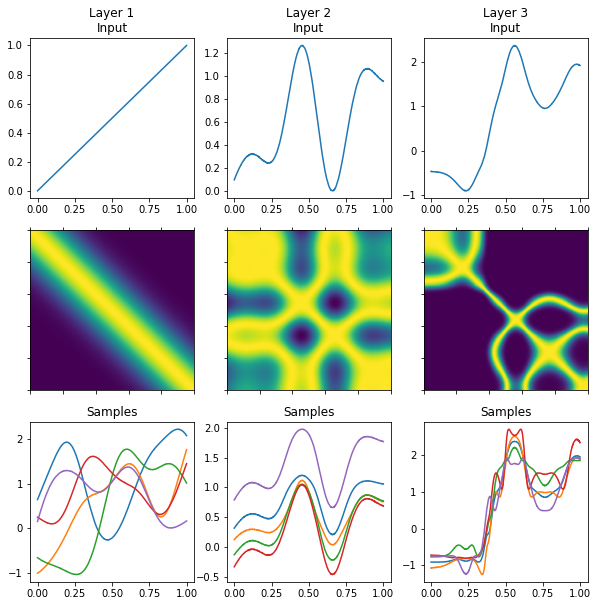

In [6]:
plot_layers(X, model)
plt.show()